In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
%load_ext tensorboard
!rm -rf ./logs/

In [ ]:
import os, sys, glob, re, time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from keras.layers import Conv2D, MaxPooling2D, Dense, Input, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard


In [ ]:
def numerical_sort(value):
    """
    Splits out any digits in a filename, turns it into an actual number, and returns the result for sorting.
    :param value: filename
    :return:

    author: kei
    date: 20190903
    """
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts


def explore_ds(path, file_type):
  print(path) #print path
  os.chdir(path)
  ds = sorted(glob.glob(file_type), key=numerical_sort)
  # print(ds) #print contents
  return ds


def visualize_ds(images, vis=False):
  
  samples = len(images)
  # print('total images', samples)

  if vis:
    fig = plt.figure(figsize=(10,samples))
    fig.subplots_adjust(hspace=0.1)
  
  for p in range(samples):
    img = plt.imread(images[p])
    img = cv2.resize(img, (width, height))

    BATCH.append(img) #global variable

    if vis:
      ax = fig.add_subplot(samples//2, 4, p+1)
      ax.axis('off')
      ax.imshow(img)
    

def process_ds(dir_list):
  for group in dir_list:
    images = explore_ds(os.path.join(path, dir, group), '*.jpg')
    visualize_ds(images, vis=False)
    # break



# clone sample images
path = '/content/drive/MyDrive/ds/pushing'
sys.path.append(path)
dirs = os.listdir(path)

height = 320
width = 320
BATCH = []

start = time.time()
for dir in dirs:
  dir_list = explore_ds(os.path.join(path, dir), 'group*')
  process_ds(dir_list)
  break
  

end = time.time()
print('total time spent {}'.format((end-start)/60))

print(len(BATCH))


/content/drive/MyDrive/ds/pushing/04
/content/drive/MyDrive/ds/pushing/04/group113
/content/drive/MyDrive/ds/pushing/04/group119
/content/drive/MyDrive/ds/pushing/04/group120
/content/drive/MyDrive/ds/pushing/04/group124
/content/drive/MyDrive/ds/pushing/04/group125
/content/drive/MyDrive/ds/pushing/04/group126
/content/drive/MyDrive/ds/pushing/04/group127
/content/drive/MyDrive/ds/pushing/04/group128
/content/drive/MyDrive/ds/pushing/04/group131
total time spent 2.7166536172231037
545


In [ ]:
start = time.time()

ds = tf.stack(BATCH) #create tensor of samples

end = time.time()
print('total time spent {}'.format((end-start)/60))


total time spent 1.2673758268356323


In [ ]:
ratio = int(len(ds)*.7)

train_ds = ds[1:ratio,:]
test_ds = ds[ratio:,:]

print(train_ds.shape, test_ds.shape)


(380, 320, 320, 3) (164, 320, 320, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(380, 320, 320, 3)


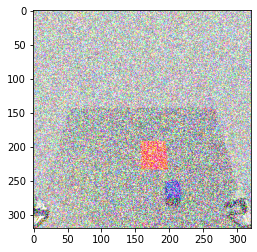

In [ ]:
# adds the gaussian noise based on the mean and the standard deviation 
def add_gaussian_noise(data):
  mean = (10, 10, 10)
  std = (50, 50, 50)
  row, col, channel = data.shape
  noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')
  return data + noise
  
def add_gaussian_to_dataset(data):
  count = 0
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_noise(data[count]))
    count+=1
  return np.array(output_data)


gaussian_train_ds = add_gaussian_to_dataset(train_ds)
gaussian_test_ds = add_gaussian_to_dataset(test_ds)

plt.imshow(gaussian_train_ds[1,:])
print(gaussian_train_ds.shape)

In [ ]:
train_ds = train_ds / 255
test_ds = test_ds / 255

# # reduce images
gaussian_train_ds = gaussian_train_ds / 255.0 
gaussian_test_ds = gaussian_test_ds / 255.0

In [ ]:
# https://www.tensorflow.org/tutorials/generative/autoencoder
# put the Activation layer AFTER the BatchNormalization() layer


class Autoencoder(tf.keras.Model):

  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
  
    self.encoder = tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape=(width, height, 3)),
          
          tf.keras.layers.Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'),
          tf.keras.layers.BatchNormalization(),
          # tf.keras.layers.MaxPool2D(padding='same'),
          
          tf.keras.layers.Conv2D(16, kernel_size=3, strides=2, padding='same', activation='relu'),
          tf.keras.layers.BatchNormalization(),
          # tf.keras.layers.MaxPool2D(padding='same'),          

          tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'),
          tf.keras.layers.BatchNormalization(),
          # tf.keras.layers.MaxPool2D(padding='same'),          
          
          tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(dropout),

          tf.keras.layers.Flatten(),
          tf.keras.layers.BatchNormalization(),
          # tf.keras.layers.Dropout(dropout),

          tf.keras.layers.Dense(1000, activation='tanh'),
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Dense(self.latent_dim, activation='tanh'),
          tf.keras.layers.BatchNormalization(),

        ])
  
    self.decoder = tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),

          tf.keras.layers.Dense(1000, activation='tanh'),
          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Dense(size_*size_*channels_, activation='tanh'),
          # tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(dropout),

          tf.keras.layers.Reshape(target_shape=(size_, size_, channels_)),
          tf.keras.layers.BatchNormalization(),
          # tf.keras.layers.Dropout(dropout),

          tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
          tf.keras.layers.BatchNormalization(),
          # tf.keras.layers.UpSampling2D(),

          tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
          tf.keras.layers.BatchNormalization(),
          # tf.keras.layers.UpSampling2D(),
          
          tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu'),
          tf.keras.layers.BatchNormalization(),
          # tf.keras.layers.UpSampling2D(),
          
          tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, padding='same', activation='relu'),
          tf.keras.layers.BatchNormalization(),
          # tf.keras.layers.UpSampling2D(),
          
          tf.keras.layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='relu'), #sigmoid
          tf.keras.layers.BatchNormalization(),

        ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    
    return decoded


# initialize the model
latent_dim = 100
size_ = 20
channels_ = 64
dropout = 0.25

gaussian_auto_encoder = Autoencoder(latent_dim)

# opt = tf.keras.optimizers.Adam(learning_rate=0.005)
opt = tf.keras.optimizers.Adamax(learning_rate=0.05)

gaussian_auto_encoder.compile(loss='mse', optimizer=opt)

# see model summary
gaussian_auto_encoder.encoder.summary()
gaussian_auto_encoder.decoder.summary()


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 160, 160, 8)       224       
_________________________________________________________________
batch_normalization_229 (Bat (None, 160, 160, 8)       32        
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 80, 80, 16)        1168      
_________________________________________________________________
batch_normalization_230 (Bat (None, 80, 80, 16)        64        
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 40, 40, 32)        4640      
_________________________________________________________________
batch_normalization_231 (Bat (None, 40, 40, 32)        128       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 20, 20, 64)      

In [ ]:
start = time.time()

# create checkpoint and save best weight
checkpoint_path = "/content/ae_cp/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 mode='min',
                                                 save_best_only=True)

# early stopping if not changing for 50 epochs
early_stop = EarlyStopping(monitor='val_loss',
                                    patience=200)

# reduce learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                factor=0.1,
                                                patience=50, 
                                                verbose=1,
                                                min_lr=0.00001)

# train the model
gaussian_history = gaussian_auto_encoder.fit(gaussian_train_ds,
                                            train_ds, 
                                            epochs=500, 
                                            batch_size=32,
                                            shuffle=True,
                                            validation_data=(gaussian_test_ds, test_ds),
                                            callbacks=[cp_callback, early_stop, reduce_lr])

end = time.time()
print('\ntotal time spent {}'.format((end-start)/60))

Epoch 1/500
12/12 [==============================] - 5s 221ms/step - loss: 0.5851 - val_loss: 0.0202

Epoch 00001: val_loss improved from inf to 0.02018, saving model to /content/ae_cp/cp.ckpt
Epoch 2/500
12/12 [==============================] - 2s 182ms/step - loss: 0.0963 - val_loss: 0.0171

Epoch 00002: val_loss improved from 0.02018 to 0.01715, saving model to /content/ae_cp/cp.ckpt
Epoch 3/500
12/12 [==============================] - 2s 182ms/step - loss: 0.0143 - val_loss: 0.0158

Epoch 00003: val_loss improved from 0.01715 to 0.01579, saving model to /content/ae_cp/cp.ckpt
Epoch 4/500
12/12 [==============================] - 2s 181ms/step - loss: 0.0071 - val_loss: 0.0137

Epoch 00004: val_loss improved from 0.01579 to 0.01370, saving model to /content/ae_cp/cp.ckpt
Epoch 5/500
12/12 [==============================] - 2s 184ms/step - loss: 0.0078 - val_loss: 0.0120

Epoch 00005: val_loss improved from 0.01370 to 0.01202, saving model to /content/ae_cp/cp.ckpt
Epoch 6/500
12/12 [

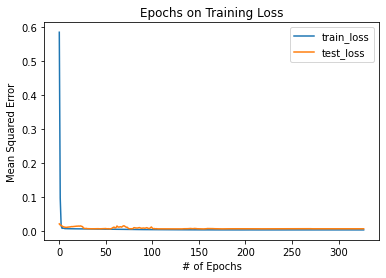

In [ ]:
plt.plot(gaussian_history.epoch, gaussian_history.history['loss'], label='train_loss')
plt.plot(gaussian_history.epoch, gaussian_history.history['val_loss'], label='test_loss')
plt.title('Epochs on Training Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
# # load_best_checkpoint and evaluate
cp_model = Autoencoder(latent_dim)
cp_model.compile(loss='mse', optimizer=opt)
cp_model.load_weights(checkpoint_path)
cp_loss = cp_model.evaluate(gaussian_test_ds, test_ds)

# evaluate the model on the test set
final_loss = gaussian_auto_encoder.evaluate(gaussian_test_ds, test_ds)

6/6 [==============================] - 0s 59ms/step - loss: 0.0058


# DENOISED IMAGES

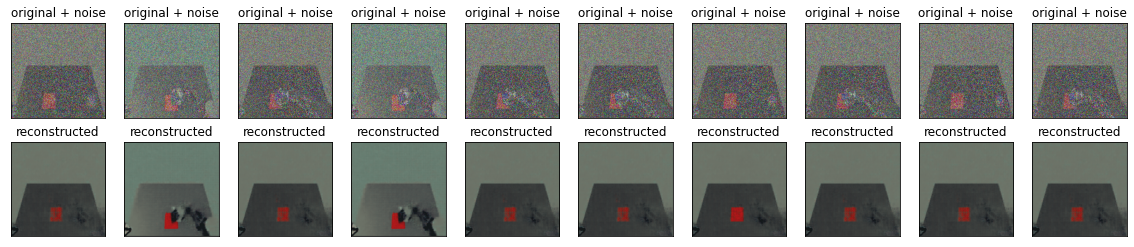

In [ ]:
# run model on the test_ds to reconstruct
cp_result = cp_model.predict(gaussian_test_ds)

n = 10
idx = [np.random.randint(1,100) for i in range(n)]
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow((gaussian_test_ds[idx[i]]*255).astype(np.uint8))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow((cp_result[idx[i]]*255).astype(np.uint8))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

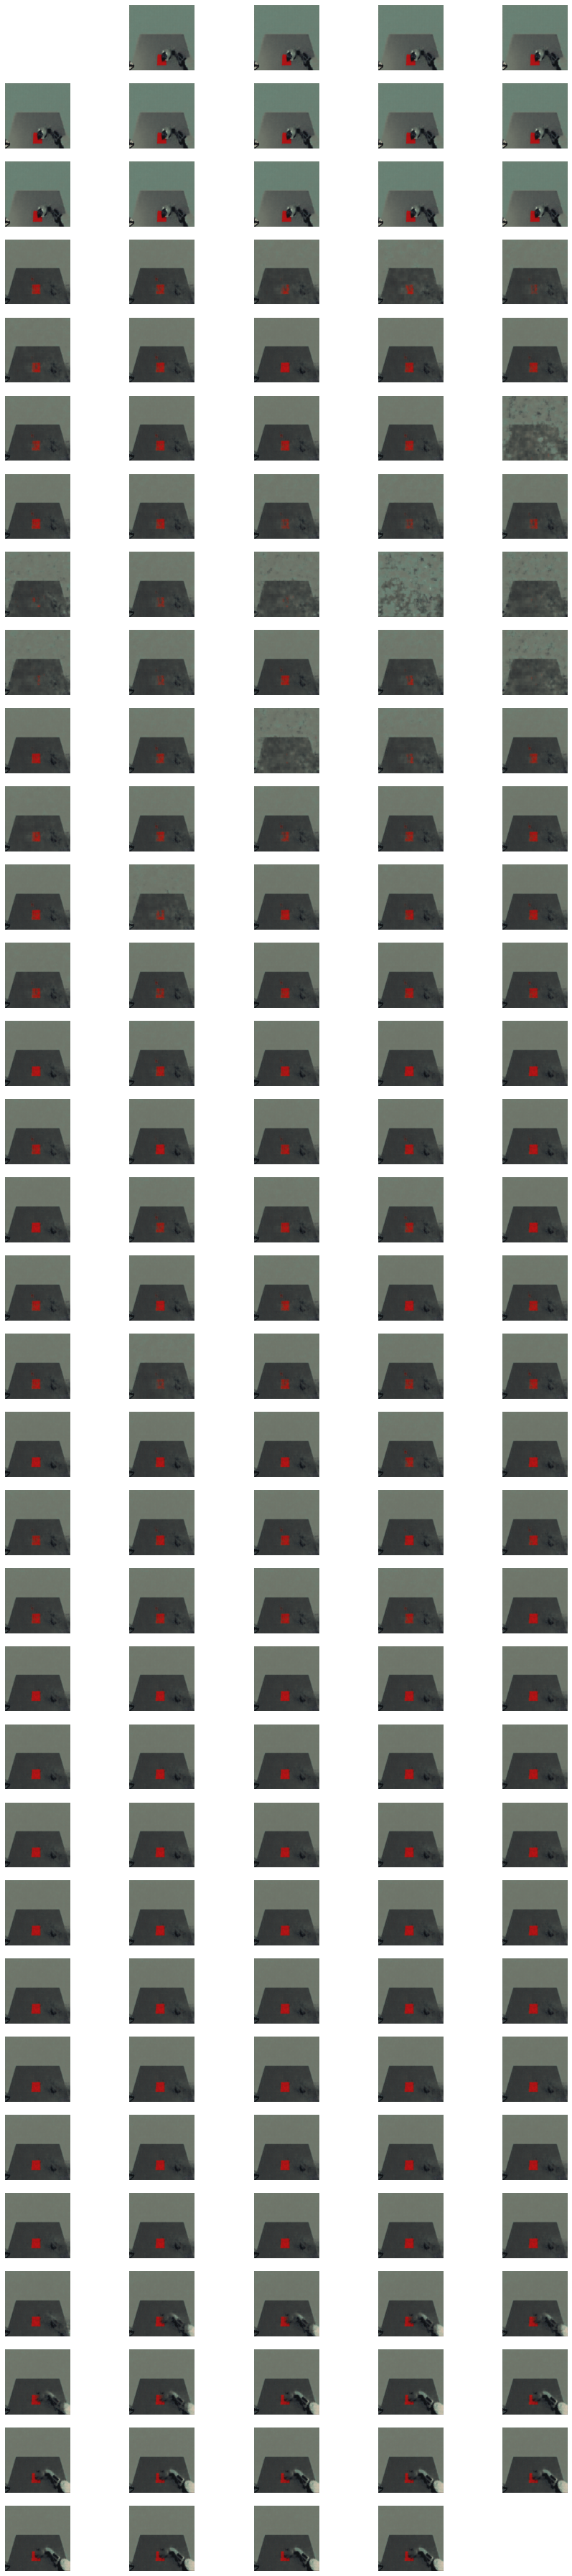

In [ ]:
final_result = gaussian_auto_encoder.predict(gaussian_test_ds)

samples = len(final_result)
fig = plt.figure(figsize=(15, samples))
for p in range(1, samples):
  ax = fig.add_subplot(samples//2, 5, p+1)
  ax.imshow((final_result[p]*255).astype(np.uint8))
  ax.axis('off')

# Original Test Images

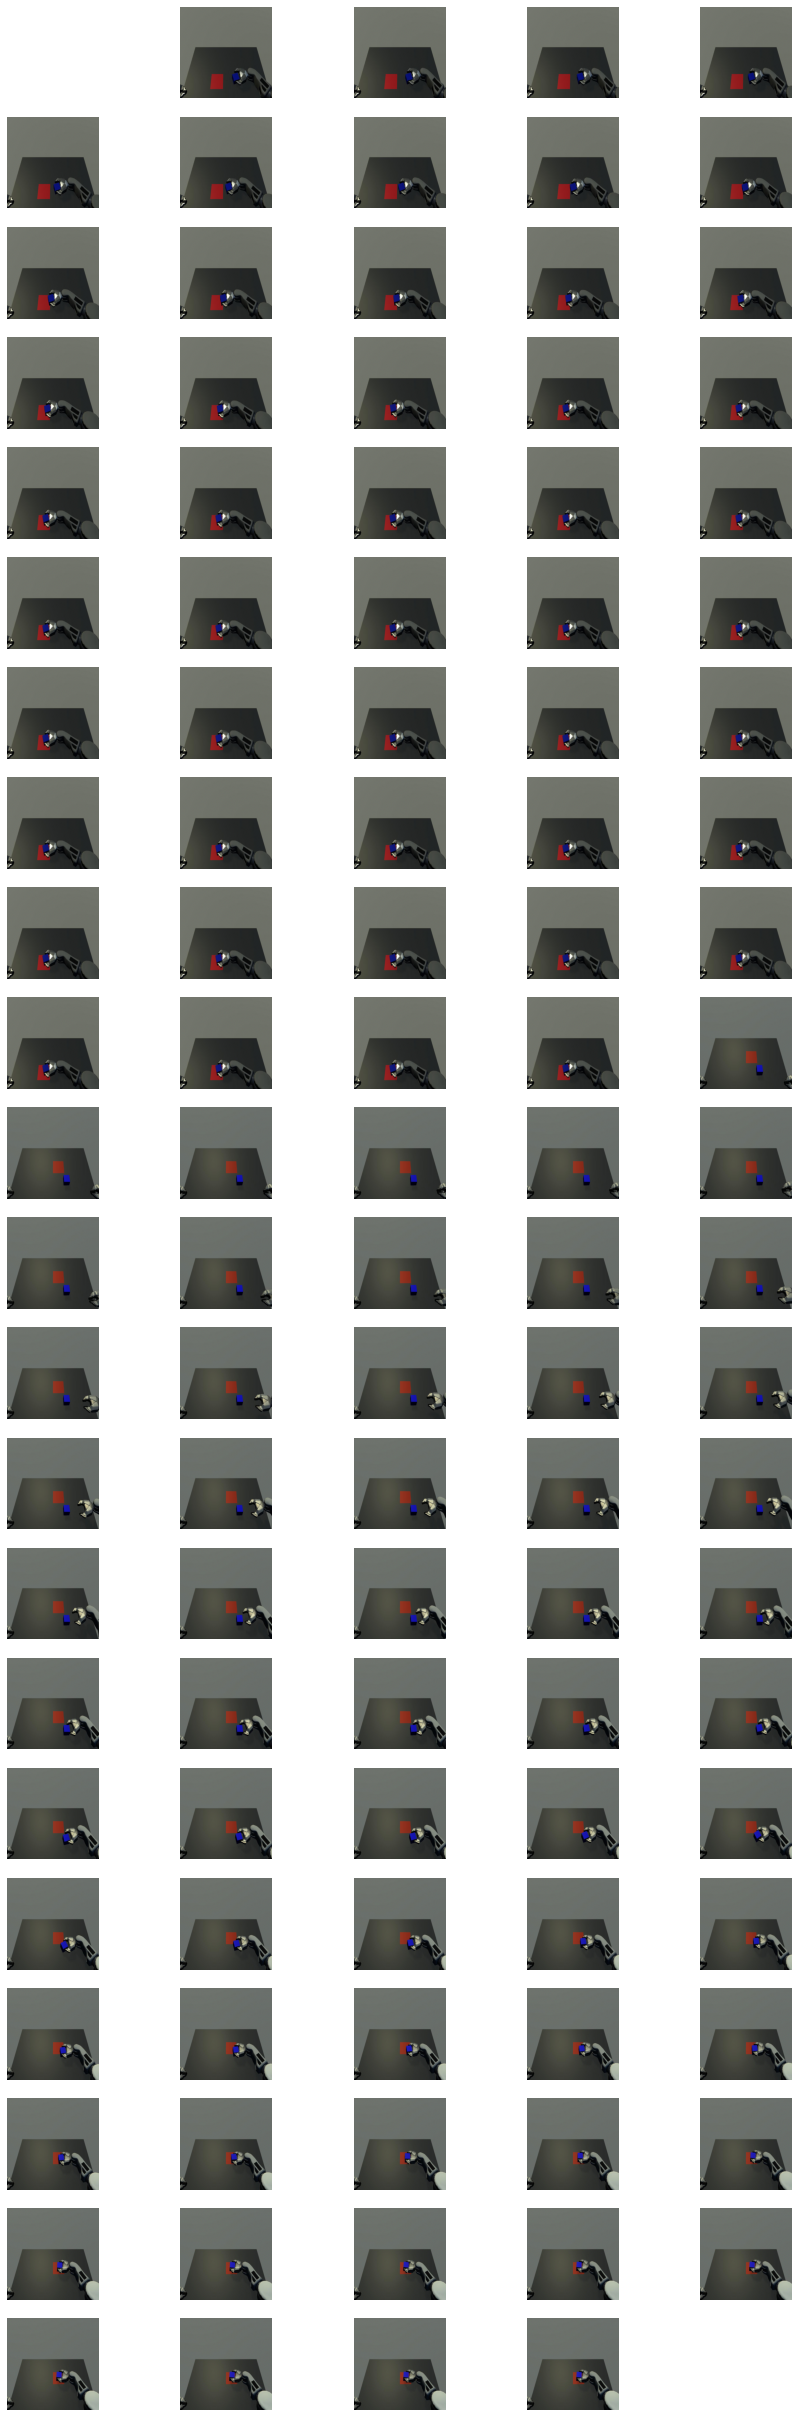

In [ ]:
fig = plt.figure(figsize=(15, samples))
for p in range(1, samples):
  ax = fig.add_subplot(samples//2, 5, p+1)
  ax.imshow(test_ds[p])
  ax.axis('off')